# Prererequisites

## Load packages and set up the environment

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pandas as pd
import seaborn as sns
import random
from scipy.stats import pearsonr
import scanpy.external as sce

## Loading the dataset

In [2]:
adata_facs = sc.read_h5ad("/Users/aumchampaneri/Databases/tabula-muris-senis-facs-processed-official-annotations-Kidney.h5ad")
adata_drop = sc.read_h5ad("/Users/aumchampaneri/Databases/tabula-muris-senis-droplet-processed-official-annotations-Kidney.h5ad")

/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/aumchampaneri/.pyenv/versions/miniconda3-latest/lib/python3.12/site-packages/anndata/compat/__init__.py:363: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connect

### Check structure of the data

In [3]:
adata_facs

AnnData object with n_obs × n_vars = 1833 × 22966
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
adata_drop

AnnData object with n_obs × n_vars = 21647 × 20138
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'age_colors', 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Merge the two datasets

In [5]:
adata = adata_facs.concatenate(adata_drop,
                               batch_key='method',
                               batch_categories=['FACS', 'Droplet'],
                               join='outer' # 'outer' to keep all genes
                               )

adata

/var/folders/dk/j41qmgy16b5_49s_wh137t_m0000gn/T/ipykernel_86339/1416867206.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_facs.concatenate(adata_drop,


AnnData object with n_obs × n_vars = 23480 × 22988
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'louvain', 'leiden', 'tissue_free_annotation'
    var: 'n_cells-Droplet', 'means-Droplet', 'dispersions-Droplet', 'dispersions_norm-Droplet', 'highly_variable-Droplet', 'n_cells-FACS', 'means-FACS', 'dispersions-FACS', 'dispersions_norm-FACS', 'highly_variable-FACS'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

# Preprocess Data and Quality Control

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


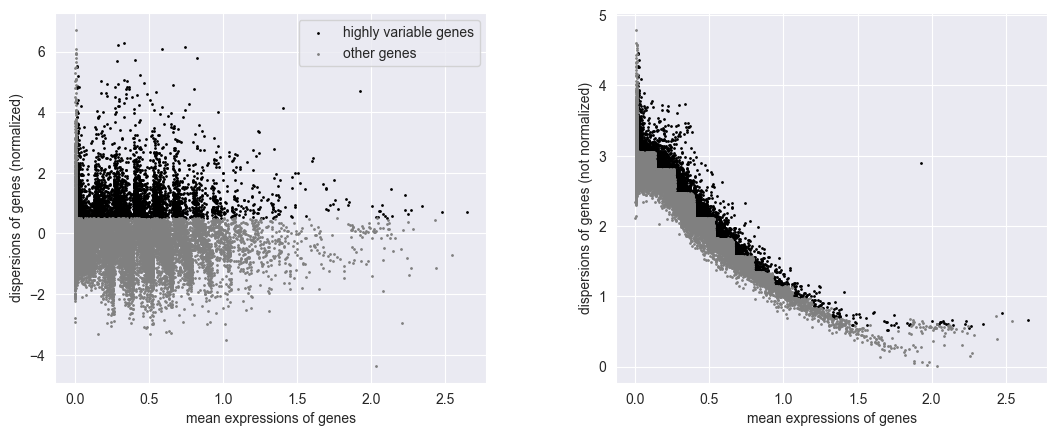

In [6]:
# Basic filtering

# Filter out cells that express fewer than 500 genes to remove low-quality cells, empty droplets, and debris.
sc.pp.filter_cells(adata, min_genes=500, inplace=True)
# Filter out genes that are detected in fewer than 3 cells to eliminate technical noise and very rarely expressed genes.
sc.pp.filter_genes(adata, min_cells=3, inplace=True)

# Normalize, log-transform, and scale the data

# Normalize the total gene expression in each cell to a target sum of 10,000 to correct for differences in sequencing depth.
sc.pp.normalize_total(adata, target_sum=1e4)
# Apply a natural logarithm transformation to the normalized data to stabilize variance and make expression values more comparable.
sc.pp.log1p(adata)

# Identify and plot highly-variable genes

# Identify highly-variable genes based on their mean expression and dispersion.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Generate PCA and UMAP embeddings + Dendrogram Keys

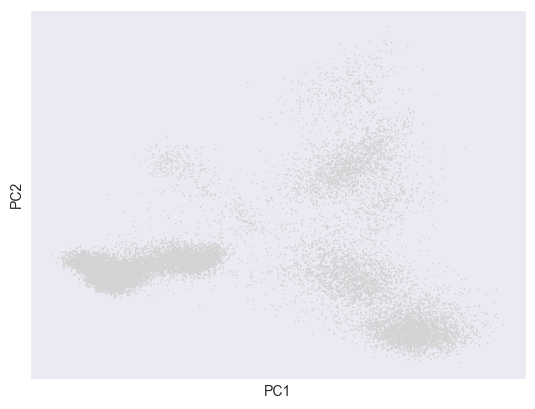

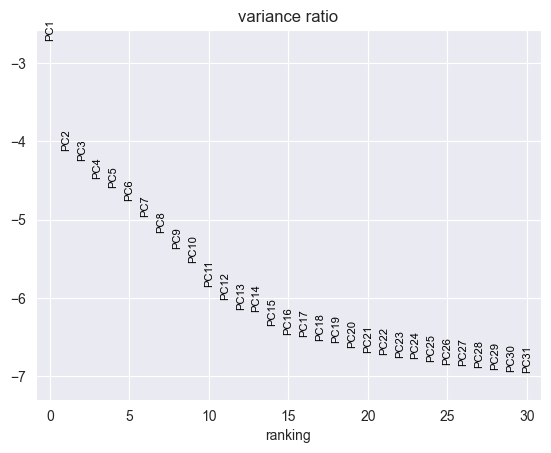

2025-03-28 22:12:13,960 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


In [ ]:
# Principal Component Analysis (PCA)
sc.pp.pca(adata, svd_solver="arpack")
# Plot the PCA -- Uncomment to see the plot
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

# Generate UMAP
sce.pp.harmony_integrate(adata, "method")
sc.pp.neighbors(adata, use_rep='X_pca_harmony', key_added='harmony')
sc.tl.umap(adata, neighbors_key='harmony')

# Leiden clustering
sc.tl.leiden(adata, flavor='igraph', n_iterations=2)
sc.pl.umap(adata, color=['cell_type']) # Looks better with dark background

# Dendrogram Key for downstream visualization
sc.tl.dendrogram(adata, groupby='cell_type')
sc.tl.dendrogram(adata, groupby='tissue')

# Dictionaries

## Gene Dictionaries

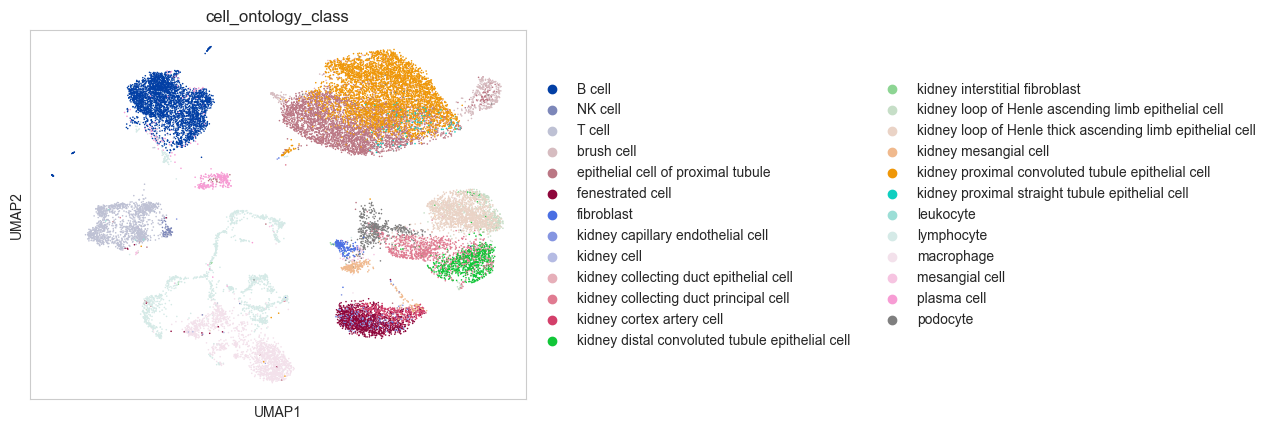

In [40]:
# All Complement Genes
gene_ensembl = sc.queries.biomart_annotations("mmusculus",
                                              ["ensembl_gene_id", "external_gene_name"],
                                              host='www.ensembl.org'
                                              )

mouse_gene_names = [
    'C1d', 'C1qa', 'C1qb', 'C1qc', 'C1qbp', 'C1r', 'C1rl', 'C1s', 'C2', 'C3', 'C3ar1', 'C4a',
    'C4b', 'C4bp', 'C4bpb', 'Hc', 'C5ar1', 'C5ar2', 'C6', 'C7', 'C8a', 'C8b', 'C8g', 'C9',
    'Calr', 'Cd46', 'Cd55', 'Cd59a', 'Cd93', 'Cfb', 'Cfd', 'Cfh', 'Cfhr1', 'Cfhr2', 'Cfhr3',
    'Cfhr4', 'Cfhr5', 'Cfi', 'Clu', 'Colec10', 'Colec11', 'Cpb2', 'Cpn1', 'Cpn2', 'Csmd1',
    'Cfp', 'Cr1', 'Cr2', 'Fcn1', 'Fcn2', 'Fcn3', 'Itgam', 'Itgamx', 'Itgax', 'Itgb2', 'Masp1',
    'Masp2', 'Masp3', 'Mbl2', 'Serping1', 'Susd4', 'Vsig4', 'Vcp'
]

# Find the mouse_gene_names in the gene_ensembl DataFrame
mouse_gene_names = set(mouse_gene_names)
gene_ensembl_names = set(gene_ensembl["external_gene_name"].values)

# Find the intersection
intersection = mouse_gene_names.intersection(gene_ensembl_names)

# Filter the gene_ensembl DataFrame to include only the intersecting genes
filtered_gene_ensembl = gene_ensembl[gene_ensembl["external_gene_name"].isin(intersection)]

# Alphabetize the DataFrame by external_gene_name
filtered_gene_ensembl = filtered_gene_ensembl.sort_values(by="external_gene_name")

# Reset the index
filtered_gene_ensembl = filtered_gene_ensembl.reset_index(drop=True)

# Create a dictionary with gene names on the left and Ensembl codes on the right
gene_dict = dict(zip(filtered_gene_ensembl["external_gene_name"], filtered_gene_ensembl["ensembl_gene_id"]))

# Print the dictionary
print(gene_dict)

# Extract keys and values into separate lists
gene_dict_names = list(gene_dict.keys())
gene_dict_keys = list(gene_dict.values())

print("gene_names =", gene_dict_names)
print("gene_keys =", gene_dict_keys)

# Create filter gene object
def filter_genes(gene_dict_names, genes_to_remove):
    # Filter out genes that are in the genes_to_remove list
    filtered_genes = [gene for gene in gene_dict_names if gene not in genes_to_remove]
    return filtered_genes

# Example list of genes to remove
genes_to_remove = ['C1QA', 'C1QB', 'C1QC', 'C1QBP']

# Get the filtered gene list
filtered_gene_list = filter_genes(gene_dict, genes_to_remove)
print(filtered_gene_list)


## Cell Type Dictionaries

In [41]:
# List all the cell types in the dataset
cell_types = adata.obs['cell_type'].unique()
print("Cell Types:")
for cell_type in cell_types:
    print(f"  {cell_type}")

# Define the groups for cell types
cell_type_groups = {
    'Myeloid Cells': ['macrophage', 'neutrophil', 'dendritic cell'],
    'Kidney Cells': ['podocyte', 'mesangial cell'],
    'Endothelial Cells': ['endothelial cell', 'kidney afferent arteriole endothelial cell',
                          'kidney efferent arteriole endothelial cell', 'glomerular endothelial cell',
                          'vasa recta descending limb cell'],
    'Fibroblasts': ['fibroblast'],
    'Epithelial Cells': ['kidney loop of Henle medullary thick ascending limb epithelial cell',
                         'kidney collecting duct principal cell', 'epithelial cell of proximal tubule',
                         'kidney distal convoluted tubule epithelial cell', 'kidney loop of Henle epithelial cell',
                         'kidney connecting tubule epithelial cell', 'kidney loop of Henle cortical thick ascending limb epithelial cell',
                         'renal alpha-intercalated cell', 'kidney cortex tubule cell', 'kidney glomerular epithelial cell',
                         'macula densa epithelial cell', 'kidney loop of Henle thin ascending limb epithelial cell',
                         'kidney loop of Henle thin descending limb epithelial cell', 'renal beta-intercalated cell',
                         'kidney collecting duct epithelial cell'],
    'Immune Cells': ['T cell', 'B cell', 'natural killer cell'],
    'Smooth Muscle Cells': ['pericyte'],
    'Unknown': ['unknown']
}


# Map cell types to groups
adata.obs['cell_type_group'] = 'Other'
for group, cell_types in cell_type_groups.items():
    adata.obs.loc[adata.obs['cell_type'].isin(cell_types), 'cell_type_group'] = group

# Check the new amount of cell types
cell_type_groups = adata.obs['cell_type_group'].unique()
print("Cell Type Groups:")
for group in cell_type_groups:
    print(f"  {group}")

,n_cells-Droplet,means-Droplet,dispersions-Droplet,dispersions_norm-Droplet,highly_variable-Droplet,n_cells-FACS,means-FACS,dispersions-FACS,dispersions_norm-FACS,highly_variable-FACS,n_cells,highly_variable,means,dispersions,dispersions_norm
index,,,,,,,,,,,,,,,
0610005C13Rik,11813.0,0.716700,1.308658,0.150452,False,3939.0,0.976980,2.545933,-0.199323,False,7384,False,0.793768,1.351787,-1.168584
0610007C21Rik,131072.0,0.887568,0.913229,-0.685100,False,61891.0,1.121900,3.934652,1.550666,True,12089,False,1.018504,1.091817,0.038137
0610007L01Rik,76760.0,0.330852,0.775849,-0.475333,False,36115.0,0.278381,1.870253,0.369994,False,5097,False,0.634851,1.592588,-1.103616
0610007N19Rik,47468.0,0.880904,1.331588,-0.137930,False,19591.0,0.192434,1.834338,0.350685,False,9209,True,0.848940,1.431616,1.209828
0610007P08Rik,17839.0,0.100118,0.695718,-0.189506,False,12581.0,0.069291,2.176712,0.534759,True,1673,False,0.369395,2.232004,-0.601726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyx,128613.0,0.427978,1.114461,0.180040,False,58021.0,0.533792,2.170801,-0.522704,False,5839,False,0.694880,1.567786,0.463458
Zzef1,37470.0,0.203353,0.697303,-0.186511,False,26577.0,0.217934,2.283547,0.592198,True,3303,False,0.514521,1.947200,-0.529475
Zzz3,41389.0,0.232334,0.720518,-0.142640,False,23403.0,0.158892,2.482636,0.699237,True,3688,False,0.527290,1.840631,-1.170455


# Plotting the Data

## UMAP Plots